# TOP

In [1]:
%reset -f
import ROOT, math

ROOT.ROOT.EnableImplicitMT(6)

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetGridColor(16)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)
ROOT.gStyle.SetPadRightMargin(0.05)
ROOT.gStyle.SetPadLeftMargin(0.09)
ROOT.gStyle.SetPadBottomMargin(0.11)
ROOT.gStyle.SetTitleSize(0.075, 'XY')
ROOT.gStyle.SetLabelSize(0.07, 'XY')
ROOT.gStyle.SetTitleOffset(0.8, 'X')
ROOT.gStyle.SetTitleOffset(0.65, 'Y')
ROOT.gStyle.SetMarkerSize(2)


%run -i ../eppi0_columns.py

fname = "../data/lvl2_eppi0.inb.qa.root"
#fname = "../data/lvl2_eppi0.outb.qa.root"

dsid = 'inb' if 'inb' in fname else 'outb'

df = ROOT.RDataFrame("h22",fname)

df = define_eppi0_columns_using_proton(df)

%run -i ../eppi0_binning_scheme_v3.py
df  = define_eppi0_bins(df, dsid)


#___________________________________________________________________________________

ecorrfile = '../code/utsav.inb.ele3phis.code' if 'inb' in fname else '../code/utsav.outb.ele3phis.code'
with open(ecorrfile) as ff:
    df = df.Define("fe", ff.read()+"return fe;")


#___________________________________________________________________________________

lowbandcode = """
double dc1th = atan2(sqrt(dcx1*dcx1 + dcy1*dcy1), dcz1)*TMath::RadToDeg();
bool lowband = dc1th < (-53.14680163254601 + 79.61307254040804*pow(pp-0.3, 0.05739232362022314));
"""
inbelosscode = lowbandcode+"""
double dploss = exp(-2.739 - 3.932*pp) + 0.002907;
if(!lowband) dploss = exp(-1.2 - 4.228*pp) + 0.007502;
"""
outbelosscode = lowbandcode+"""
double dploss = exp(-2.739 - 3.932*pp) + 0.002907;
if(!lowband) dploss = exp(-1.871 - 3.063*pp) + 0.007517;
"""
losscode = inbelosscode if 'inb' in fname else outbelosscode

df = df.Define("feloss", losscode+"return (pp+dploss)/pp;")

Welcome to JupyROOT 6.24/06


-------------------------
-------------------------

# Proton momentum corrections

In [2]:
inbpcorrcode = """
double pfac = 0.5;
if(psec==1) pfac = 0.8;
else if(psec==2) pfac = 0.7;
else if(psec==6) pfac = 1;
"""
outbpcorrcode = """
double pfac = 0;
if(psec==2) pfac = 0.3;
else if(psec==5) pfac = -0.5;
"""
pcorrcode = inbpcorrcode if 'inb' in fname else outbpcorrcode

-------------------------
-------------------------

# Filling: MM2 vs proton momentum

In [3]:
pplims = [0.3,0.6,0.7,0.85,1,1.05,1.2,1.3,1.4,1.5,2,2.5,3] if 'inb' in fname else [0.5,0.7,0.9,1.2,1.5,2,2.7,4]
#[0.5,0.7,1,1.5,2,2.7,4]

mm2names = 'mm2a,mm2b,mm2c,mm2d'

h2s = {}
bdf0 = df.Define("mm2s","""
TLorentzVector beam(0,0,10.6041,10.6041), targ(0,0,0,0.938);
TLorentzVector ele0, ele1, pro0, pro1, pro2;

""" + pcorrcode + """

double dpp=pfac*(feloss*pp-pp);

double fpcorr = (feloss*pp + dpp)/pp;

ele0.SetXYZM(ex, ey, ez, 0);
ele1.SetXYZM(fe*ex, fe*ey, fe*ez, 0);

pro0.SetXYZM(px, py, pz, 0.938);
pro1.SetXYZM(feloss*px, feloss*py, feloss*pz, 0.938);
pro2.SetXYZM(fpcorr*px, fpcorr*py, fpcorr*pz, 0.938);

double mm2a = (beam+targ-ele0-pro2).M2();
double mm2b = (beam+targ-ele1-pro0).M2();
double mm2c = (beam+targ-ele1-pro1).M2();
double mm2d = (beam+targ-ele1-pro2).M2();

return vector<double>{"""+mm2names+"""};;
""")

for imm,mm2name in enumerate(mm2names.split(',')):
    bdf0 = bdf0.Define(mm2name,f"mm2s[{imm}]")

for mm2name in mm2names.split(','):
    for sec in range(1,7):
        bdf1 = bdf0.Filter(f"psec=={sec}")
        h2 = bdf1.Histo2D((str((mm2name,sec)), str((mm2name,sec)), 100,0.3,3, 100,-0.6,0.5), "pp", mm2name)
        h2s[(mm2name,sec)]=h2
        setattr(h2, 'h1s', {})

        for pp0,pp1 in zip(pplims[:-1], pplims[1:]):
            bdf2 = bdf1.Filter(f"pp>{pp0} && pp<{pp1}")
            h1 = bdf2.Histo1D((str((mm2name,sec,pp0,pp1)), str((mm2name,sec,pp0,pp1)), 200,-0.6,0.5), mm2name)
            ppm = bdf2.Mean("pp")

            h2.h1s[ppm] = h1

-------------------------
-------------------------

## fitting: proton slices

In [4]:
def fitslice(h1):
    f1 = ROOT.TF1("f1"+h1.GetName(), "gaus(0)+pol1(3)", -0.53,0.34)
    #f1.SetLineWidth(1)
    f1.SetParameters(1,0,0.1,1,1)
    f1.SetParLimits(1,-0.4,0.31)
    f1.SetParLimits(2,0.01,0.21)
    h1.Fit(f1,"QR")
    mu,sig = f1.GetParameter(1), f1.GetParameter(2)
    f1.SetRange(mu-3*sig, mu+3*sig)
    h1.Fit(f1,"QR")
    setattr(h1,'f1',f1)
    return f1

for key in h2s:
    h2 = h2s[key]
    gr = ROOT.TGraphErrors()
    gr.SetTitle(h2.GetName())
    setattr(h2,'gr',gr)
    for ppm in h2.h1s:
        h1 = h2.h1s[ppm]
        f1 = fitslice(h1)
        gr.SetPoint(gr.GetN(), ppm.GetValue(), f1.GetParameter(1))
        gr.SetPointError(gr.GetN()-1, 0, f1.GetParError(1))


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


-------------------------
-------------------------

## plotting: proton graphs

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


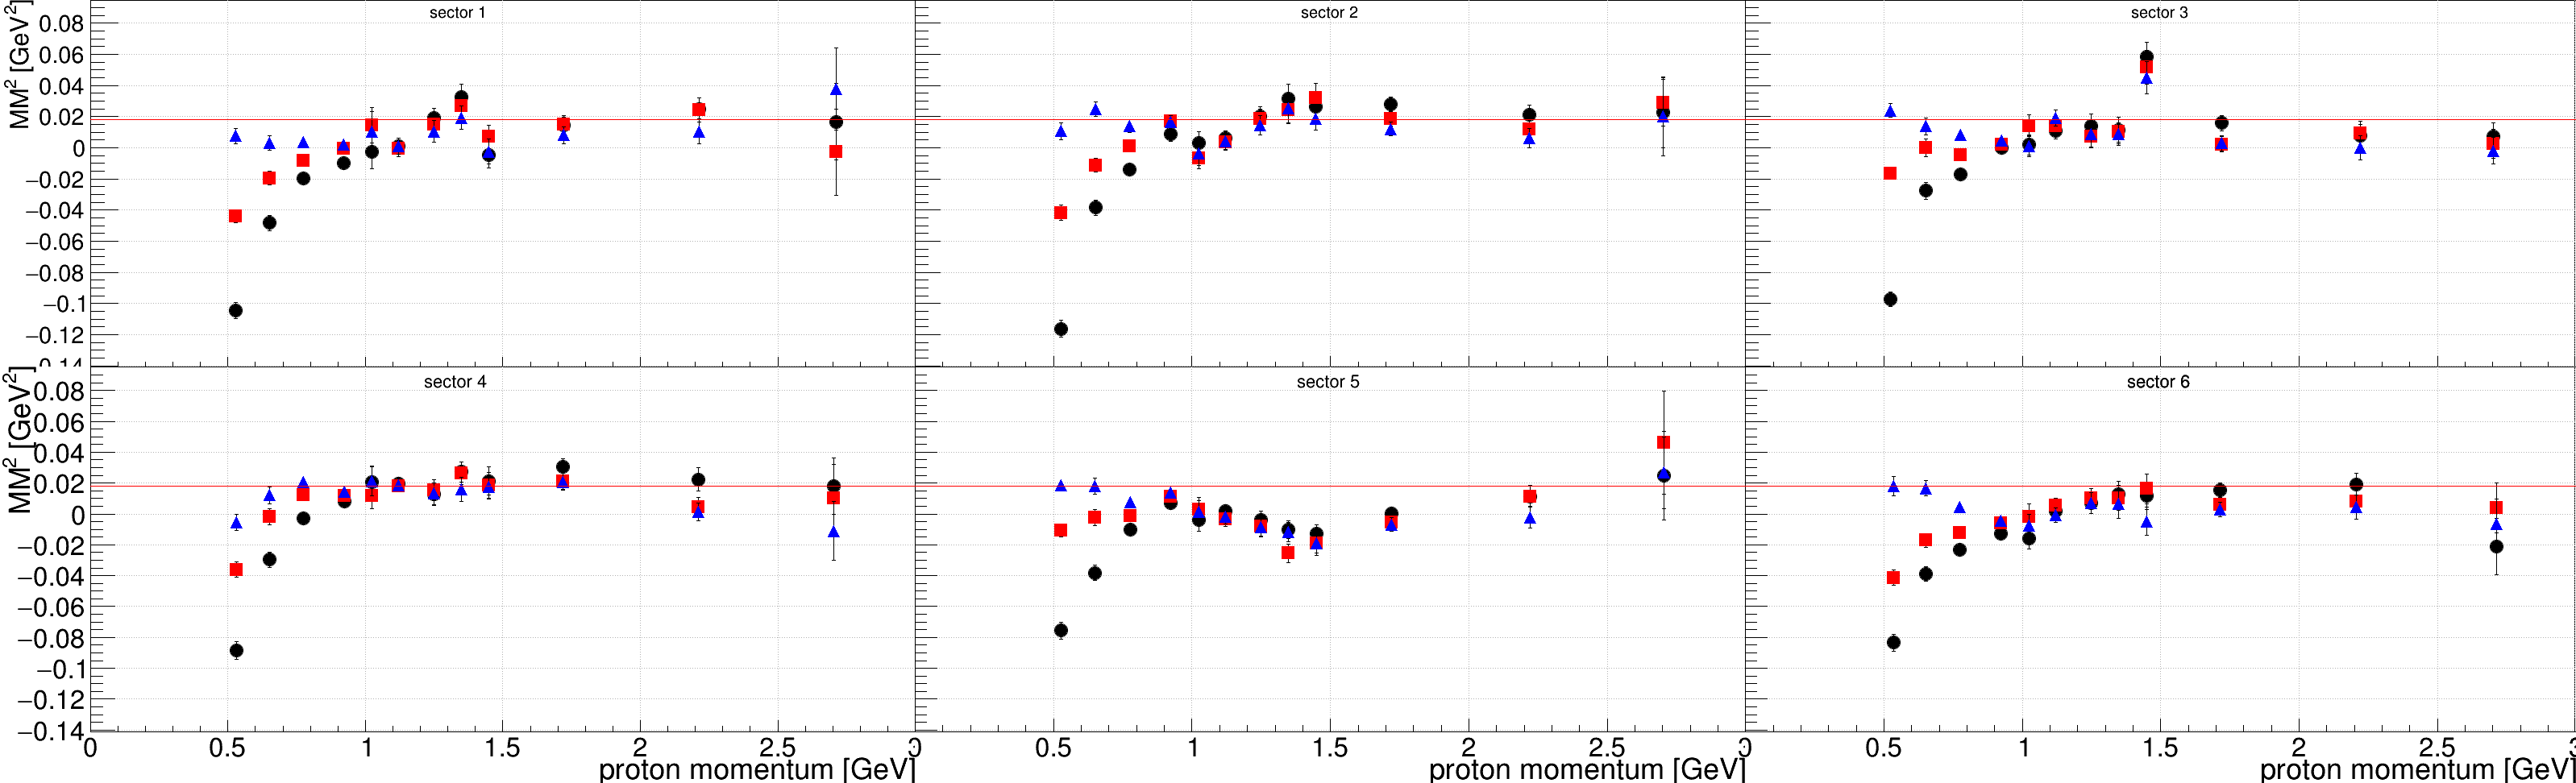

In [5]:
c1 = ROOT.TCanvas("c1","c1",3200,1000)
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)
c1.Draw()

ll = ROOT.TLine()
ll.SetLineColor(2)

for sec in range(1,7):
    h1 = c1.cd(sec).DrawFrame(0,-0.141,3,0.095)
    if 'outb' in fname: h1 = c1.cd(sec).DrawFrame(0,-0.057,3,0.095)
    c1.cd(sec).SetGrid()
    gr1 = h2s[('mm2b',sec)].gr
    gr1.Draw("P")
    gr1.SetMarkerStyle(20)
    gr2 = h2s[('mm2c',sec)].gr
    gr2.Draw("P")
    gr2.SetMarkerStyle(21)
    gr2.SetMarkerColor(2)
    gr3 = h2s[('mm2d',sec)].gr
    gr3.Draw("P")
    gr3.SetMarkerStyle(22)
    gr3.SetMarkerColor(4)
    h1.SetTitle(f"sector {sec};proton momentum [GeV];MM^{{2}} [GeV^{{2}}]")
    ll.DrawLine(0,0.018225,3,0.018225)

#c1.Print(f"../pdf/eppi0.pcorr.mm2vspp.graph.{dsid}.pdf")

-------------------------
-------------------------

## plotting: proton slices

In [6]:
c1s=[]

ll = ROOT.TLine()
ll.SetLineColor(2)
for mm2name in mm2names.split(','):
    c1 = ROOT.TCanvas(f"c{mm2name}", f"c{mm2name}", 2500,2000)
    c1s.append(c1)
    c1.Divide(len(pplims)-1,6,0,0)
    #c1.Draw()

    ipad=0
    for sec in range(1,7):
        h2 = h2s[(mm2name,sec)]
        for ppm in h2.h1s:
            ipad+=1
            c1.cd(ipad)
            
            h1 = h2.h1s[ppm]
            ppm = ppm.GetValue()
            h1.Draw()
            
            ll.DrawLine(0.018225,0,0.018225,h1.GetMaximum()*1.1)


-------------------------
-------------------------

# Filling: MM2 vs electron momentum after all corrections

In [7]:
h2as,h2ds = [],[]
pelims = [3,4,5, 5.5,6,6.5,7,7.5,8]

for esec in range(1,7):
    edf = bdf0.Filter(f"esec=={esec}")
    h2a = edf.Histo2D((str(("hmm2a pe",esec)), f"sector {esec};electron momentum [GeV];MM^{{2}} [GeV^{{2}}]", 100,1,8, 100,-0.5,0.5), "pe", "mm2a")
    h2as.append(h2a)
    h2d = edf.Histo2D((str(("hmm2d pe",esec)), f"sector {esec};electron momentum [GeV];MM^{{2}} [GeV^{{2}}]", 100,1,8, 100,-0.5,0.5), "pe", "mm2d")
    h2ds.append(h2d)
    
    setattr(h2a, "pms", [])
    setattr(h2d, "pms", [])
    setattr(h2a, "h1s", [])
    setattr(h2d, "h1s", [])
    
    for pe0,pe1 in zip(pelims[:-1], pelims[1:]):
        edf1 = edf.Filter(f"pe>{pe0} && pe<{pe1}")
        h1a = edf1.Histo1D((str(('mm2a',esec,pe0,pe1)), str(('mm2a',esec,pe0,pe1)), 200,-0.5,0.5), "mm2a")
        h1d = edf1.Histo1D((str(('mm2d',esec,pe0,pe1)), str(('mm2d',esec,pe0,pe1)), 200,-0.5,0.5), "mm2d")
        pm = edf1.Mean("pe")

        h2a.h1s.append(h1a)
        h2a.pms.append(pm)

        h2d.h1s.append(h1d)
        h2d.pms.append(pm)

-------------------------
-------------------------

## fitting/plotting: electron slices

In [8]:
def fitslices(h2):
    setattr(h2, "gr", ROOT.TGraphErrors())
    for pm,h1 in zip(h2.pms, h2.h1s):
        f1 = ROOT.TF1("f1"+h1.GetName(), "gaus(0)+pol1(3)", -0.33,0.34)
        f1.SetLineWidth(1)
        f1.SetParameters(1,0,0.1,1,1)
        f1.SetParLimits(1,-0.1,0.15)
        f1.SetParLimits(2,0.01,0.21)
        h1.Fit(f1,"QR")
        mu,sig = f1.GetParameter(1), f1.GetParameter(2)
        f1.SetRange(mu-3*sig, mu+3*sig)
        h1.Fit(f1,"QR")
        h2.gr.SetPoint(h2.gr.GetN(), pm.GetValue(), f1.GetParameter(1))
        h2.gr.SetPointError(h2.gr.GetN()-1, 0, f1.GetParError(1))

c1s=[]
for sec in range(1,7):
    c1 = ROOT.TCanvas(f"c{sec}","canvas",2400,1000)
    #c1.Draw()
    c1s.append(c1)

    h2a,h2d = h2as[sec-1], h2ds[sec-1]

    fitslices(h2a)
    fitslices(h2d)

    c1.Clear()
    c1.Divide(4,2,0,0)
    
    ipad = 0
    for pm,h1 in zip(h2a.pms,h2a.h1s):
        ipad+=1
        c1.cd(ipad)
        h1.Draw()


-------------------------
-------------------------

## plotting: electron graphs

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


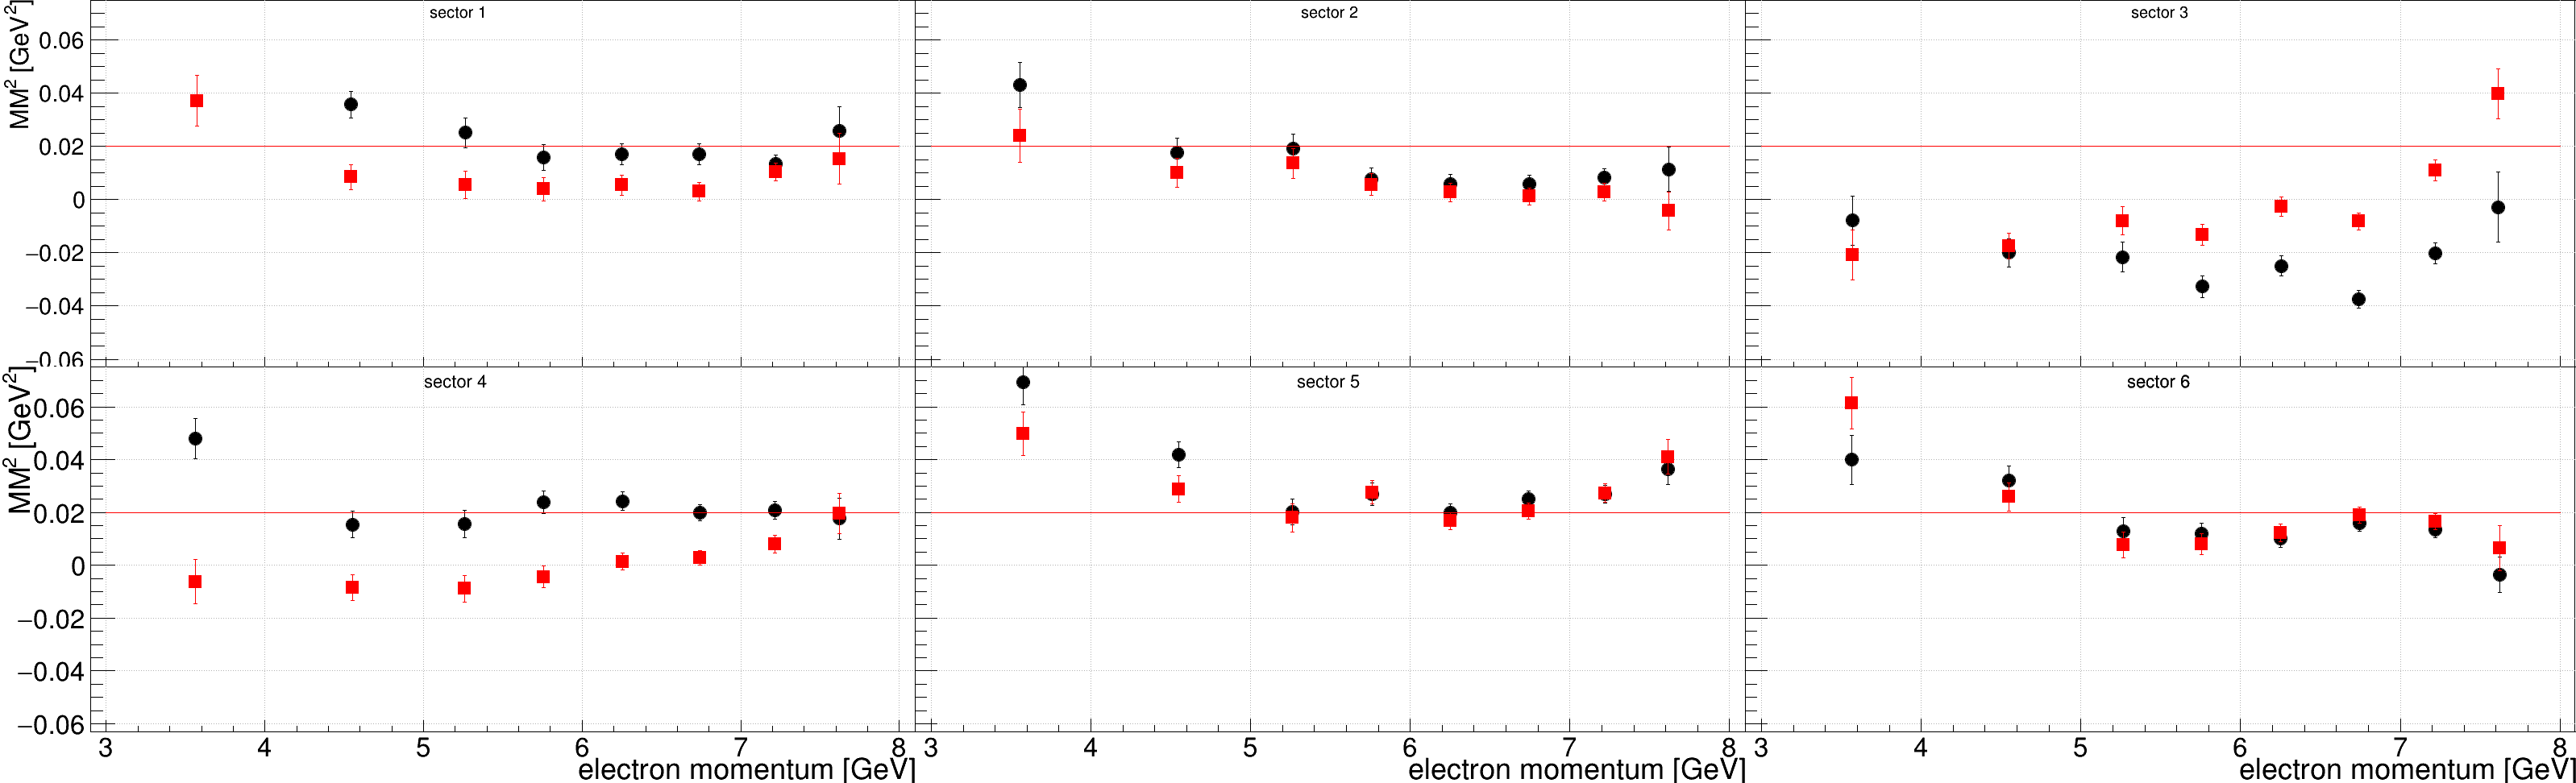

In [9]:
c1 = ROOT.TCanvas("c1","canvas",3200,1000)
c1.Draw()
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,2,0,0)

ll = ROOT.TLine()
ll.SetLineColor(2)


for sec in range(1,7):
    c1.cd(sec).DrawFrame(2.9,-0.063,8.1,0.075).SetTitle(f"sector {sec};electron momentum [GeV];MM^{{2}} [GeV^{{2}}]")
    if 'outb' in fname:
        c1.cd(sec).DrawFrame(2.9,-0.082,8.1,0.145).SetTitle(f"sector {sec};electron momentum [GeV];MM^{{2}} [GeV^{{2}}]")

    h2a,h2d = h2as[sec-1],h2ds[sec-1]
    h2a.gr.SetMarkerStyle(20)
    h2d.gr.SetMarkerStyle(21)

    h2d.gr.SetMarkerColor(2)
    h2d.gr.SetLineColor(2)

    h2a.gr.Draw("P")
    h2d.gr.Draw("P")
    
    ll.DrawLine(3,0.02,8,0.02)
    
#c1.Print(f"../pdf/eppi0.ecorr.mm2vspe.graph1.{dsid}.pdf")

-------------------------
-------------------------